<h1><center>Deep Neural Networks (AI341) - Assignment No. 2 </center></h1>

# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](Dataset.png)

In this assignment, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories, you will also learn to optimize your model through different techniques covered in your class.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow.

# Table of content

[1. Introduction to keras](#intro_keras)<br>
[2. A first look at the data set](#dataset)<br>
[3. A first naive model](#first_model)<br>
[4. Interpreting the results](#results)<br>
[4.1 Making predictions](#results_prediction)<br>
[4.2 Evaluating the results](#results_evaluation)<br>



<a id='intro_keras'></a>

## 0 - Introduction to Keras

Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production, with three key advantages:

- __User friendly__: Keras has a simple, consistent interface optimized for common use cases. It provides clear and actionable feedback for user errors.
- __Modular and composable__: Keras models are made by connecting configurable building blocks together, with few restrictions.
- __Easy to extend__: Write custom building blocks to express new ideas for research. Create new layers, loss functions, and develop state-of-the-art models.

In Keras, models are built by assymbling multiple layers.  Suppose we want to create a new multilayer perceptron model to categorize 128-feature data into 10 labeled categories.  Keras code looks like:

```python
# Create a sequential model
model = keras.models.Sequential()
# Adds a densely-connected layer with 64 units to the model
model.add(layers.Dense(64, activation='relu'), input_shape=[128])
# Add another
model.add(layers.Dense(32, activation='relu'))
# Add a softmax layer with 10 output units
model.add(layers.Dense(10, activation='softmax'))
```

The `input_shape` argument must be given for the first layer in the model, however all other layers will automatically determine the input shape based on the previous layer in the model.  Note that the code above is substantially simpler than the corresponding TensorFlow code.  This is particularly useful for building convolutional or other types of layers, as we will see.

Once built, a model's learning can be configured with the `compile()` function:

```python
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.train.AdamOptimizer(0.001), 
    metrics=['accuracy'])
```

In this case, a cross-entropy loss function is used with the ADAM optimization algorithm.  The `metrics` argument allows the model to keep track of a number of [training metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) during training.

Once configured, training is performed using the `fit()` function.

```python
model.fit(data, labels, epochs=10, batch_size=32)
```

The function takes an array-like (could be numpy array) of data and the corresponding target values, and performs the optimization of the learnable parameters in the model.  See the documentation for the [fit()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#fit) function for more details.

Once trained, the model can be used to predict, using the `predict()` function. 

```python
prediction = model.predict(new_data)
```

<a id='dataset'></a>
# 1 - Understanding the data set

Begin by importing the necessary modules.

In [101]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

Understanding your dataset is the first prerequisit to training any model.  The CIFAR-10 dataset can be loaded directly from Keras.

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data, and in what format it is provided.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [91]:
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

**2) Verify that the shape of the image and target arrays are what you expect.**


In [92]:
print("Training images shape",train_images.shape)
print("Test images shape",test_images.shape)

Training images shape (50000, 32, 32, 3)
Test images shape (10000, 32, 32, 3)


We now create a list of labels corresponding to the 10 categories.  It will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows:

  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [93]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

**3) Normalize the image data from [0,255] to be [0,1].  Normalizing improves model training (to test this, you can comment out the normalization later).**

In [94]:
train_images = train_images/255.0
test_images = test_images/255.0

**4) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.np_utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [95]:
train_labels = to_categorical(train_labels,num_classes = 10)
test_labels = to_categorical(test_labels,num_classes = 10)

**5) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure below?  Hint: the below figure was created using the first 8 images belonging to each category in the training data.**

![Dataset.png](attachment:Dataset.png)

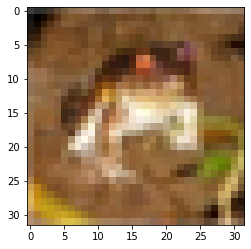

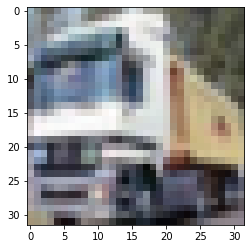

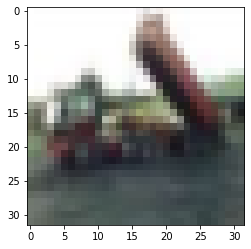

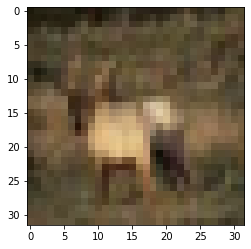

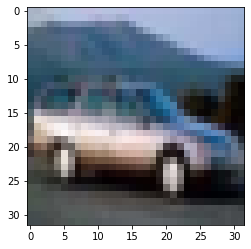

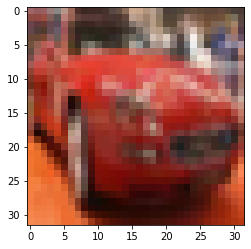

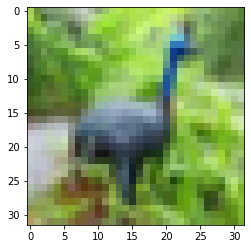

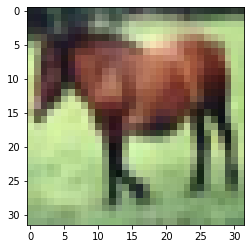

In [7]:
for i in range(8):
  plt.imshow(train_images[i])
  plt.show()

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**6) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a final output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, and the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [8]:
model = Sequential()
model.add(Flatten(input_shape=[32,32,3]))
model.add(Dense(2048, activation='relu', input_dim = 1024))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer= 'SGD', metrics=['accuracy'])

**7) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

The total number of parameters would be 2099200 + 2098176 + 524416 + 131328 + 2570 = 4516870


**8) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [119]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

**9) Train the model:**
  - Start with a small batch size of 32 and train for 10 epochs
  - Use early stopping on the validation accuracy with a patience of 2 (use 10% of your training set as the validation set)
  
**How does the model perform?**

In [10]:
history = model.fit(train_images,train_labels,batch_size = 32,epochs = 10, callbacks = EarlyStopping(monitor = 'val_loss',patience= 2),validation_split= 0.1)

Epoch 1/10
1407/1407 [==============================] - 9s 5ms/step - loss: 1.8446 - accuracy: 0.3371 - val_loss: 1.8010 - val_accuracy: 0.3502
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.6442 - accuracy: 0.4129 - val_loss: 1.7463 - val_accuracy: 0.3758
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.5548 - accuracy: 0.4465 - val_loss: 1.6013 - val_accuracy: 0.4306
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4937 - accuracy: 0.4698 - val_loss: 1.4954 - val_accuracy: 0.4636
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4419 - accuracy: 0.4851 - val_loss: 1.8041 - val_accuracy: 0.3522
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.3976 - accuracy: 0.5026 - val_loss: 1.4399 - val_accuracy: 0.4862
Epoch 7/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.3513 - accuracy: 0.5188 - val_loss: 1.5196 - val_accuracy:

**10) Try changing the batch size to see if there is any improvement.**

In [11]:
history = model.fit(train_images,train_labels,batch_size = 64,epochs = 10,callbacks = EarlyStopping(monitor = 'val_loss',patience= 2), validation_split= 0.1)

Epoch 1/10
704/704 [==============================] - 3s 5ms/step - loss: 1.2148 - accuracy: 0.5702 - val_loss: 1.4262 - val_accuracy: 0.4876
Epoch 2/10
704/704 [==============================] - 4s 6ms/step - loss: 1.1881 - accuracy: 0.5799 - val_loss: 2.2260 - val_accuracy: 0.3080
Epoch 3/10
704/704 [==============================] - 3s 4ms/step - loss: 1.1644 - accuracy: 0.5902 - val_loss: 2.0026 - val_accuracy: 0.3992


**11) Try adding batch normalization after each hidden layer.  Any better?**

In [12]:
model2 = Sequential()
model2.add(Flatten(input_shape=[32,32,3]))
model2.add(Dense(2048, activation='relu', input_dim = 1024))
model2.add(BatchNormalization())
model2.add(Dense(1024, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [13]:
model2.build(input_shape=(None,32,32,3))
model2.compile(loss='categorical_crossentropy', optimizer= 'SGD', metrics=['accuracy'])

In [14]:
model2.fit(train_images,train_labels,batch_size = 32,epochs = 10, callbacks = EarlyStopping(monitor = 'val_loss',patience= 2),validation_split= 0.1)

Epoch 1/10
1407/1407 [==============================] - 10s 6ms/step - loss: 1.7130 - accuracy: 0.3946 - val_loss: 1.6493 - val_accuracy: 0.4154
Epoch 2/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4669 - accuracy: 0.4798 - val_loss: 1.5701 - val_accuracy: 0.4540
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3671 - accuracy: 0.5160 - val_loss: 1.5195 - val_accuracy: 0.4710
Epoch 4/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.3180 - accuracy: 0.5322 - val_loss: 1.7079 - val_accuracy: 0.4136
Epoch 5/10
1407/1407 [==============================] - 9s 7ms/step - loss: 1.2769 - accuracy: 0.5471 - val_loss: 1.4959 - val_accuracy: 0.4712
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.2449 - accuracy: 0.5581 - val_loss: 1.5179 - val_accuracy: 0.4678
Epoch 7/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.2244 - accuracy: 0.5628 - val_loss: 2.8591 - val_accur

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general). In this task, you will build a convolutional network and see how it performs during training.

**12) Create a new model with the following layers**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes
  
**Compile the network with same optimizer and metrics as the dense network.**  

In [15]:
cnmodel = Sequential()
cnmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnmodel.add(Conv2D(32, (3, 3), activation='relu'))
cnmodel.add(MaxPooling2D((2, 2)))
cnmodel.add(Conv2D(64, (3, 3), activation='relu',))
cnmodel.add(Conv2D(64, (3, 3), activation='relu',))
cnmodel.add(MaxPooling2D((2, 2)))
cnmodel.add(Flatten(input_shape=[32,32,3]))
cnmodel.add(Dense(512, activation='relu',input_dim = 1024))
cnmodel.add(Dense(10, activation='softmax'))

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

In [16]:
cnmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

**14) Use the same training procedure as before for 10 epochs and batch size of 32. How does the validation accuracy change with each epoch?**

In [17]:
cnmodel.compile(loss='categorical_crossentropy', optimizer= 'SGD', metrics=['accuracy'])
history = cnmodel.fit(train_images, train_labels,batch_size = 32, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 14s 5ms/step - loss: 2.0271 - accuracy: 0.2541 - val_loss: 1.8973 - val_accuracy: 0.3036
Epoch 2/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6317 - accuracy: 0.4120 - val_loss: 1.5171 - val_accuracy: 0.4496
Epoch 3/10
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4322 - accuracy: 0.4855 - val_loss: 1.4317 - val_accuracy: 0.4834
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3098 - accuracy: 0.5358 - val_loss: 1.3881 - val_accuracy: 0.4890
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.2136 - accuracy: 0.5695 - val_loss: 1.2289 - val_accuracy: 0.5640
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.1295 - accuracy: 0.6012 - val_loss: 1.2666 - val_accuracy: 0.5440
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0528 - accuracy: 0.6330 - val_loss: 1.1308 - val_accura

**15) Increase the batch size to 64 and retrain.  Better or worse?  Try 128 as well.  How does increasing the batch size improve the training?**

In [18]:
history = cnmodel.fit(train_images, train_labels,batch_size = 64, epochs=10, validation_split=0.1)

Epoch 1/10
704/704 [==============================] - 5s 7ms/step - loss: 0.7066 - accuracy: 0.7564 - val_loss: 1.3236 - val_accuracy: 0.5824
Epoch 2/10
704/704 [==============================] - 5s 6ms/step - loss: 0.6609 - accuracy: 0.7728 - val_loss: 1.0926 - val_accuracy: 0.6412
Epoch 3/10
704/704 [==============================] - 5s 6ms/step - loss: 0.6198 - accuracy: 0.7864 - val_loss: 1.2272 - val_accuracy: 0.6296
Epoch 4/10
704/704 [==============================] - 4s 6ms/step - loss: 0.5769 - accuracy: 0.7999 - val_loss: 1.5678 - val_accuracy: 0.5444
Epoch 5/10
704/704 [==============================] - 4s 6ms/step - loss: 0.5348 - accuracy: 0.8158 - val_loss: 1.0889 - val_accuracy: 0.6632
Epoch 6/10
704/704 [==============================] - 5s 7ms/step - loss: 0.4873 - accuracy: 0.8320 - val_loss: 1.1306 - val_accuracy: 0.6636
Epoch 7/10
704/704 [==============================] - 5s 6ms/step - loss: 0.4444 - accuracy: 0.8456 - val_loss: 1.4417 - val_accuracy: 0.5944
Epoch 

In [19]:
history = cnmodel.fit(train_images, train_labels,batch_size = 128, epochs=10, validation_split=0.1)

Epoch 1/10
352/352 [==============================] - 4s 11ms/step - loss: 0.2129 - accuracy: 0.9364 - val_loss: 1.3637 - val_accuracy: 0.6712
Epoch 2/10
352/352 [==============================] - 3s 10ms/step - loss: 0.1615 - accuracy: 0.9524 - val_loss: 1.4499 - val_accuracy: 0.6628
Epoch 3/10
352/352 [==============================] - 3s 10ms/step - loss: 0.1347 - accuracy: 0.9614 - val_loss: 1.5163 - val_accuracy: 0.6722
Epoch 4/10
352/352 [==============================] - 3s 10ms/step - loss: 0.1129 - accuracy: 0.9699 - val_loss: 1.6560 - val_accuracy: 0.6642
Epoch 5/10
352/352 [==============================] - 4s 10ms/step - loss: 0.0943 - accuracy: 0.9758 - val_loss: 2.1804 - val_accuracy: 0.6218
Epoch 6/10
352/352 [==============================] - 4s 10ms/step - loss: 0.0772 - accuracy: 0.9824 - val_loss: 1.8237 - val_accuracy: 0.6608
Epoch 7/10
352/352 [==============================] - 4s 10ms/step - loss: 0.0579 - accuracy: 0.9886 - val_loss: 1.8491 - val_accuracy: 0.6688

Text(0.5, 0, 'epochs')

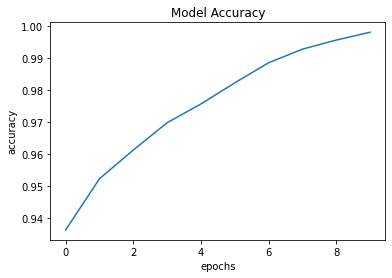

In [20]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomena called?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model?**

In [21]:
cnmodel2 = Sequential()
cnmodel2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnmodel2.add(Conv2D(32, (3, 3), activation='relu'))
cnmodel2.add(Dropout(0.25))
cnmodel2.add(MaxPooling2D((2, 2)))
cnmodel2.add(Conv2D(64, (3, 3), activation='relu',))
cnmodel2.add(Conv2D(64, (3, 3), activation='relu',))
cnmodel2.add(Dropout(0.25))
cnmodel2.add(MaxPooling2D((2, 2)))
cnmodel2.add(Flatten(input_shape=[32,32,3]))
cnmodel2.add(Dense(512, activation='relu',input_dim = 1024))
cnmodel2.add(Dropout(0.25))
cnmodel2.add(Dense(10, activation='softmax'))

In [22]:
cnmodel2.compile(loss='categorical_crossentropy', optimizer= 'SGD', metrics=['accuracy'])
history = cnmodel2.fit(train_images, train_labels,batch_size = 32, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.9812 - accuracy: 0.2745 - val_loss: 1.9185 - val_accuracy: 0.2986
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.6333 - accuracy: 0.4099 - val_loss: 1.7235 - val_accuracy: 0.4010
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4610 - accuracy: 0.4727 - val_loss: 1.5064 - val_accuracy: 0.4956
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3549 - accuracy: 0.5148 - val_loss: 1.3935 - val_accuracy: 0.5184
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.2744 - accuracy: 0.5458 - val_loss: 1.4242 - val_accuracy: 0.5012
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.2091 - accuracy: 0.5706 - val_loss: 1.3122 - val_accuracy: 0.5646
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.1516 - accuracy: 0.5894 - val_loss: 1.2878 - val_accuracy:

**17) Play with batch normalization.  For example, add batch normalization layers after each dropout layer.  Do you notice a faster increase in the model improvement? Why?**

In [23]:
cnmodel3 = Sequential()
cnmodel3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnmodel3.add(Conv2D(32, (3, 3), activation='relu'))
cnmodel3.add(Dropout(0.25))
cnmodel3.add(BatchNormalization())
cnmodel3.add(MaxPooling2D((2, 2)))
cnmodel3.add(Conv2D(64, (3, 3), activation='relu',))
cnmodel3.add(Conv2D(64, (3, 3), activation='relu',))
cnmodel3.add(Dropout(0.25))
cnmodel3.add(MaxPooling2D((2, 2)))
cnmodel3.add(Flatten(input_shape=[32,32,3]))
cnmodel3.add(Dense(512, activation='relu',input_dim = 1024))
cnmodel3.add(Dropout(0.25))
cnmodel3.add(BatchNormalization())
cnmodel3.add(Dense(10, activation='softmax'))

In [24]:
cnmodel3.compile(loss='categorical_crossentropy', optimizer= 'SGD', metrics=['accuracy'])
history = cnmodel3.fit(train_images, train_labels,batch_size = 32, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6944 - accuracy: 0.3935 - val_loss: 1.6640 - val_accuracy: 0.4038
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3143 - accuracy: 0.5354 - val_loss: 1.4409 - val_accuracy: 0.4920
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1716 - accuracy: 0.5848 - val_loss: 1.2922 - val_accuracy: 0.5486
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0667 - accuracy: 0.6216 - val_loss: 1.4408 - val_accuracy: 0.5152
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9892 - accuracy: 0.6518 - val_loss: 1.3731 - val_accuracy: 0.5216
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.9341 - accuracy: 0.6739 - val_loss: 1.3178 - val_accuracy: 0.5422
Epoch 7/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.8845 - accuracy: 0.6881 - val_loss: 1.3125 - val_accuracy:

<a id='results'></a>

# 4 - Interpreting the results
 
<a id='results_prediction'></a>

## 4.1 - Making predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![Results.png](attachment:Results.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

<!---**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.--->

In [110]:
pre = cnmodel.predict(test_images)
pre = np.argmax(pre, axis=1)

# Converting the test labels to class labels
test_label_class = np.argmax(test_labels, axis=1)

313/313 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 18ms/step


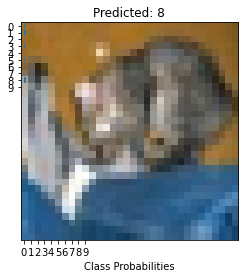

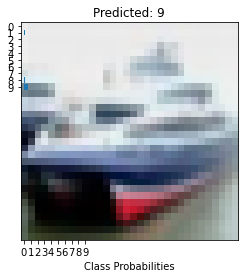

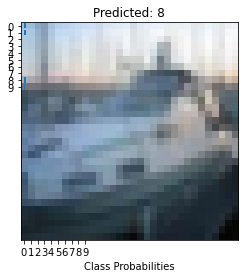

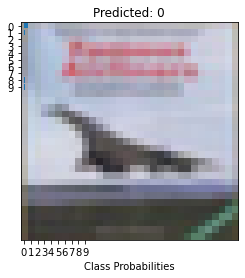

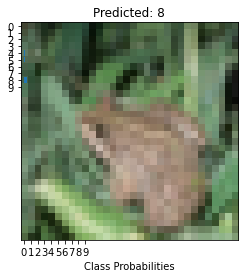

In [107]:
# Making predictions on a few example images from the test set
predictions = model.predict(test_images[:5])
for i in range(5):
    
    probs = predictions[i]
    label = np.argmax(probs)
    plt.imshow(test_images[i])
    plt.title(f'Predicted: {label}')
    plt.xlabel('Class Probabilities')
    plt.xticks(range(10), labels=range(10))
    plt.yticks(range(10), labels=range(10))
    plt.barh(range(10), width=probs)
    plt.show()


<a id='results_evaluation'></a>

## 4.2 Evaluating the results

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female:

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | male | female |
|--------|------|--------|
| male   | 3    | 2      |
| female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.  In this case, we see that the class female has a higher accuracy over male.  

**19) Create the confusion matrix for the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

[[732  24  47  29  22   5  16  11  72  42]
 [ 44 747   5  20   4   8   9  10  48 105]
 [ 63   9 515  99  94  61  77  52  18  12]
 [ 32  13  53 506  91 161  64  40  16  24]
 [ 24   4  83  88 610  51  45  76  12   7]
 [ 18   6  42 221  92 502  30  68  11  10]
 [ 15   6  37  65  48  27 769  13  10  10]
 [ 23  10  34  58  87  57  13 692   6  20]
 [ 76  40  14  15  17   5  14   4 779  36]
 [ 42  86  13  32  13  16  13  18  46 721]]


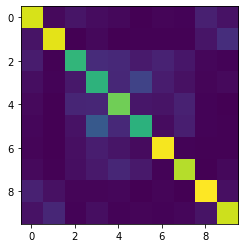

In [111]:
matrix = confusion_matrix(test_label_class, pre)
print(matrix)
plt.imshow(matrix)

<a id='pretrained_cnn'></a>
# 5 - Improving on current performances

**20) Play with different CNN architectures. Provide a few attempts (atleast 1 and atmost 3)**

Applying VGG16 and Resnet architecture and evaluating there predictions.

In [120]:
from tensorflow.keras.applications import ResNet50, VGG16
resmodel = ResNet50(include_top=True, weights=None, input_shape=(32, 32, 3), classes=10)
vggmodel = VGG16(include_top=True, weights=None, input_shape=(32, 32, 3), classes=10)

1/1 [==============================] - 1s 828ms/step


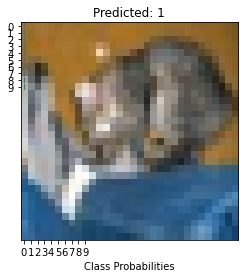

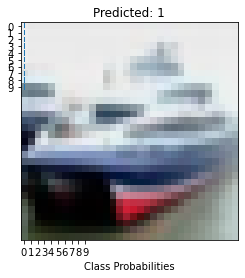

In [121]:
predictions = resmodel.predict(test_images[:2])
for i in range(2):
    
    probs = predictions[i]
    label = np.argmax(probs)
    plt.imshow(test_images[i])
    plt.title(f'Predicted: {label}')
    plt.xlabel('Class Probabilities')
    plt.xticks(range(10), labels=range(10))
    plt.yticks(range(10), labels=range(10))
    plt.barh(range(10), width=probs)
    plt.show()

1/1 [==============================] - 0s 138ms/step


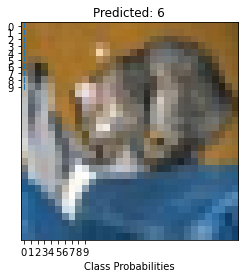

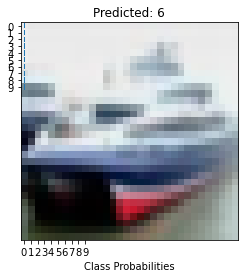

In [122]:
predictions = vggmodel.predict(test_images[:2])
for i in range(2):
    
    probs = predictions[i]
    label = np.argmax(probs)
    plt.imshow(test_images[i])
    plt.title(f'Predicted: {label}')
    plt.xlabel('Class Probabilities')
    plt.xticks(range(10), labels=range(10))
    plt.yticks(range(10), labels=range(10))
    plt.barh(range(10), width=probs)
    plt.show()

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)